# Natural Language Processing: Statistische Wortmodelle

In der 10. Übung machen wir einen kleinen Exkurs in die statistischen Modelle, um genau zu sein die n-Gram Modelle. 

Das Ziel dieser Übung ist es  ein generatives Modell aufzustellen, das, nachdem es auf einer Liste von Medikamentennamen die statistische Beschaffenheit dieser gelernt hat, zufällig neue, vorher nicht gesehene Namen generieren kann. In diesem Fall stellen die Tokens also keine Wörter, sondern einfache Buchstaben, Ziffern und andere Zeichen dar, was das Vokabular sehr klein hält und rechenintensive Vorgänge vermeidet. *Im Wesentlichen sollen also die Modelle und Grafik von Folie 17 der Vorlesung (Folie 28 im Video zur VL) Schritt für Schritt nachgebaut werden.* 

Wir benötigen Pandas um mit tabellarischen Daten zu arbeiten. Die Medikamenten Namen ziehen wir aus einer Auflistung zu verschriebenen Medikamenten bestimmter Ärzte.

In [ ]:
import pandas as pd
import numpy as np
import time

Wir benötigen im Folgenden die Datei `'medicine_prescription_records.csv'`. Zuerst laden wir die Daten aus der csv-Datei als Pandas Dataframe und schauen uns die Beschaffenheit der Daten an.

In [ ]:
# read_csv scheitert manchmal, wenn die große csv-Datei auf einmal gelesen werden soll

for retry in range(1,16):
  try:
    print('Versuche große Datei zu laden',retry)
    chunks = pd.read_csv('medicine_prescription_records.csv',header=0, chunksize=1000)
    df = pd.concat(chunks)
  except:
    print('Fehlgeschlagen!')
    time.sleep(0.5)
    continue
  break

df

Versuche große Datei zu laden 1


,Unnamed: 0,specialty,years_practicing,cms_prescription_counts
0,0,Nephrology,7,"DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL A..."
1,1,General Practice,7,"CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMINO..."
2,2,General Practice,7,"CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL"
3,3,General Practice,7,AMOXICILLIN
4,4,Nephrology,6,"PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, HY..."
...,...,...,...,...
239925,239925,Family,7,"SIMVASTATIN, NEXIUM, CHLORHEXIDINE GLUCONATE, ..."
239926,239926,Surgical Technologist,2,"SANTYL, CLOPIDOGREL"
239927,239927,Psych/Mental Health,3,"HYDROXYZINE PAMOATE, BUSPIRONE HCL, SEROQUEL X..."
239928,239928,Family,2,"CIPROFLOXACIN HCL, AMOXICILLIN, IBUPROFEN, NEX..."


Uns interessiert nur die letzte Spalte mit den Medikamenten.

In [ ]:
texts = df.iloc[:,3]

a) Extrahiere die Namen aller Medikamente, sodass du eine Liste mit einzigartigen Strings erhälst

In [ ]:
words = list()
for i in range(texts.shape[0]):
  words.extend(texts[i].split(', '))
words_unique_s = set(words)
words_unique = list(words_unique_s)

In [ ]:
print('Anzahl an Medikamenten',len(words_unique))

Anzahl an Medikamenten 2397


`Anzahl an Medikamenten: 2397`

b) Implementiere die Funktion `prepare_n_gram`, welche eine Liste mit Wörtern und ein n (für das n-Gram) erhält und die Wörter tokenized und **entsprechend des Modell-Grades** um Start- und Endtokens ergänzt. Ein Token entspricht hierbei gerade einem Zeichen. Die neue Liste sollte also  beispielsweise Wörter der Form `['<s>','A','S','P','I','R','I','N','</s>'] `enthalten.

In [ ]:
def prepare_n_gram(list_words,n):
  sep_words = list()
  start_tokens = ['<s>' for i in range(n-1)]
  end_tokens = ['</s>' for i in range(n-1)]
  for w in list_words:
    sep_words.append(start_tokens+list(w)+end_tokens)  
  return sep_words

In [ ]:
sep_words = prepare_n_gram(words_unique,3)

c) Implementiere die Funktion `train_model`, welche tokenized Trainingsdaten und das gewünschte n>1 (also minimal bigram) erhält und ein generatives Modell für das n-Gram zurückgibt, also auf Basis eines übergebenen n-Grams die Wahrscheinlichkeitsverteilung über den nächsten Token zurückgibt. Das Modell soll ein Dictionary der Form {$q$ : $P(T_k=t|T_{k-n+1:k-1}=q)$} sein.
Außerdem soll das verwendete Vokabular zurückgegeben werden. Das ist eine Liste, welche zu den Wahrscheinlichkeiten die entspechend geordneten Tokens enthält.

*Anmerkung: Da das Vokabular in diesem Fall nur aus einzelnen Buchstaben besteht und wir nur aus diesem Samplen werden, ist es nicht erforderlich extra Tokens für unbekannte Wörter/Symbole anzulegen.*

In [ ]:
def train_model(prepared_data,n):
  '''
  Params:
    prepared_data: List[List[str]]
    n: int
  Return:
    model: Dict[str,ndarray]
    symols: List[str]
      Liste der Tokens aus dem Vokabular

  '''
  assert n>1
  model = dict() # {n_gram: ndarray}
  symbols = set()
  for i in range(len(prepared_data)):
    for j in range(len(prepared_data[i])):
      symbols.add(prepared_data[i][j])
  symbols = list(symbols)
  symbols.sort()
  symbols_dict = {s:i for i,s in enumerate(symbols)}
  
  
  for i,word in enumerate(prepared_data):
    for j in range(len(word)-n+1):
      lu = "".join(word[j:j+n-1])
      i_sym = symbols_dict[word[j+n-1]]
      amount = model.get(lu)
      if amount is not None:
        amount[i_sym]+=1
        model[lu]=amount
      else:
        amount = np.zeros(len(symbols))
        amount[i_sym] = 1
        model[lu] = amount
  
  for key in model:
    model[key] /= model[key].sum()


  return model,symbols

In [ ]:
model, symbols = train_model(sep_words,3)

Du kannst folgende Funktion verwenden um anhand eines Arrays mit Wahrscheinlichkeiten Indices zu samplen.

In [ ]:
def sample(a,n=1):
  '''
  Sampled einen Index (oder mehrere) aus einer Wahrscheinlichkeitsverteilung, welche als Array vorliegt.
  Params:
    a: ndarray
      Muss eine Wahrscheinlichkeitsverteilung darstellen
    n: int
      Anzahl der Samples
  Return
    index: int if n==1
           ndarray if n>1

  '''
  choices = np.prod(a.shape)
  index = np.random.choice(choices, size=n, p=a.ravel())
  if n==1:
    return index[0]  # ndarray[n_sample,n_symbol]
  else:
    return index

print(sample(model['OC']))

31


d) Implementiere die Funktion `sample_model`, welche aus einem n-Gram Modell ein neues Wort der Form `['<s>','A','S','P','I','R','I','N','</s>']` sampled und terminiert, sobald die entsprechend Anzahl Ende-Tokens erreicht ist.

In [ ]:
def sample_model(model,symbols,n):
  start_tokens = ['<s>' for i in range(n-1)]
  end_tokens = ['</s>' for i in range(n-1)]
  word = start_tokens
  while word[-n+1:]!= end_tokens:
    word.append(symbols[sample(model["".join(word[-n+1:])])])
  return word

def make_nice(word,n):
  '''
  Übersetzt tokenized Wort in String
  '''
  if n == 1:
    word = "".join(word)
  else:  
    word = "".join(word[n-1:-n+1])
  return word

e) Teste nun dein Modell, indem du ein *n* wählst, die Trainingsdaten vorbereitest, ein Modell erstellst und aus diesem Modell ein Wort samplest und dieses "schön" darstellst.

Ist das Wort eine neue Kreation oder bereits in den Trainingsdaten enthalten?

In [ ]:
n=4
sep_words = prepare_n_gram(words_unique,n)
model, symbols = train_model(sep_words,n)


In [ ]:
w = sample_model(model,symbols,n)
my_word = make_nice(w,n)
print(my_word)

print('Existiert das Wort bereits in den Trainingsdaten?', my_word in words_unique)

MATOL
Existiert das Wort bereits in den Trainingsdaten? False


f) Bislang ist das implementierte Modell kontextsensitiv. Implementiere nun außerdem das generative "bag of words" Modell (n=1)

In [ ]:
def bag_of_words(prepared_data):
  symbols = set()
  max_word = 0
  min_word = 1000
  for i in range(len(prepared_data)):
    for j in range(len(prepared_data[i])):
      symbols.add(prepared_data[i][j])
  symbols = list(symbols)
  symbols.sort()
  symbols_dict = {s:i for i,s in enumerate(symbols)}
  model = np.zeros(len(symbols_dict))
  for i,word in enumerate(prepared_data):
    if len(word)>max_word:
      max_word = len(word)
    elif len(word)<min_word:
      min_word = len(word)
    for j in range(len(word)):
      i_sym = symbols_dict[word[j]]
      model[i_sym]+=1
  model/=model.sum()
  return model,symbols,(min_word,max_word)

## (Optional) Vergleich der Modelle und Visualisierung

Vergleiche die verschiedenen generativen n-Gram Modelle (insbesondere mit dem Bag-of-Words Modell). Was stellst du fest?
Gibt es ein optimales n? Von was hängt dieses ab?
Wo sind die Nachteile der n-Gram-Modelle und haben haben wir in der Vorlesung über Verbesserungen gesprochen? 

Erstelle den Graphen, der aus der Vorlesung bekannt ist.




In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt



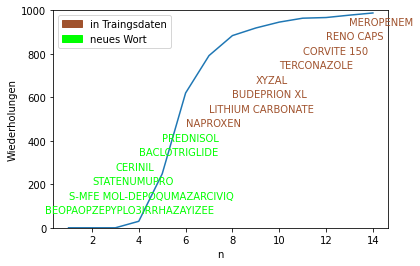

In [ ]:
n_samples = 1000
n_models = 14
words_generated=list()
n_vektor = np.arange(1,n_models+1)
count = np.zeros(n_models)

# bag of words model (1-gram)
sep_words = prepare_n_gram(words_unique,1)
model,symbols,(min_word,max_word) = bag_of_words(sep_words)
words_model=list()
for i in range(n_samples):
  word_len = np.random.randint(min_word,max_word+1)
  inds = sample(model,n=word_len) 
  w = [symbols[ind] for ind in inds]
  my_word = make_nice(w,1)
  words_model.append(my_word)
  #print(my_word)
  count[0]+= my_word in words_unique
words_generated.append(words_model)

# n-gram Model (n>1)
for n in range(2,n_models+1):
  words_model=list()
  sep_words = prepare_n_gram(words_unique,n)
  model, symbols = train_model(sep_words,n)
  for i in range(n_samples):
    w = sample_model(model,symbols,n)
    my_word = make_nice(w,n)
    words_model.append(my_word)

    #print(my_word)
    count[n-1]+= my_word in words_unique
  words_generated.append(words_model)

plt.plot(n_vektor,count)
plt.xlabel('n')
plt.ylabel('Wiederholungen')
plt.ylim((0,n_samples))
for i in range(14):
  if words_generated[i][0] in words_unique:
    color="sienna"
  else:
    color="lime"
  plt.annotate(words_generated[i][0],xy=(n_vektor[i]-0.5,n_samples/(n_models+1)*n_vektor[i]),xytext=(n_vektor[i]-1,n_samples/(n_models+1)*n_vektor[i]),color=color)
# Creating legend with color box
inlier_patch = mpatches.Patch(color='sienna', label='in Traingsdaten')
oulier_patch = mpatches.Patch(color='lime', label='neues Wort')
plt.legend(handles=[inlier_patch,oulier_patch])

In [ ]:
#create 100 words for each model that are unique
max_runs=20000
n_samples = 50
n_models = 10
words_generated=list()
n_vektor = np.arange(1,n_models+1)
count = np.zeros(n_models)

# bag of words model (1-gram)
sep_words = prepare_n_gram(words_unique,1)
model,symbols,(min_word,max_word) = bag_of_words(sep_words)
words_model=list()
for i in range(max_runs):
  word_len = np.random.randint(min_word,max_word+1)
  inds = sample(model,n=word_len) 
  w = [symbols[ind] for ind in inds]
  my_word = make_nice(w,1)
  if not (my_word in words_unique):
    words_model.append(my_word)
  #print(my_word)
  if len(words_model)==n_samples:
    break
words_generated.append(words_model)

# n-gram Model (n>1)
for n in range(2,n_models+1):
  words_model=list()
  sep_words = prepare_n_gram(words_unique,n)
  model, symbols = train_model(sep_words,n)
  for i in range(max_runs):
    w = sample_model(model,symbols,n)
    my_word = make_nice(w,n)
    if not (my_word in words_unique):
      words_model.append(my_word)
    if len(words_model)==n_samples:
      break
    #print(my_word)
  words_generated.append(words_model)


words_generated_transposed = list(zip(*words_generated))
words_table = pd.DataFrame(data=words_generated_transposed, columns=range(1,n_models+1)) 
words_table

,1,2,3,4,5,6,7,8,9,10
0,SNEAMNEOFNBISNERZMCFORLOI,ZONIZELODISTALITHYST,SE SUREVERIP PRIN,BALZIVALENORPRO,RISPERDAL COMFORTE,AZITHROMAX,FLUPHENAZINE,DORZOLAMIDE,HALDOL DECANOATE,GENTAMICIN SULFATE ER
1,R LXSSCDTSAC MNAAAUTOAHL,CTADONE,TINE,ZESS FE,CLEMASTIGMIN,ZYMAXIDEX,COLY-MYCIN ER,COLYTE WITH FLUORIDE,PENICILLIN G POTASSIUM ACETATE,OLANZAPINE-FLUOXETINE DR
2,CSNLYRSONP ARIPE,APLE,VITHOSLOR,NORDIZEMPRO,ANUSOL-HYDROCHLORIDE,QUESTRACET,METHYLERGONOVINE MAG TRISALICYLATE,POLYETHYLENE BLUE,FLUPHENAZINE DECANOATE 50,L-MEFOLATE-PYRIDOX-MECOBALAMIN-NAC
3,TCFXDHNOEIDMTZLR N,FERYRON,CHOLTOTE,FLUVOXAZOLMICON FORFIVO 75,ABRAZYME,TOLAZONE-HOMATROPINE HCL,BD INSULIN SYRINGE,NEOMYCIN-BENZOYL PEROXIDE,AMPICILLIN G SODIUM,ECONAZOLE IN SALINE
4,IANED NDAY,VEMPRYFM,NULFATTS D2,BROVITAZOLE USE ANHYDROFLOXAC,VANCOCINONIDE HCL,CORTISONE ACETONIDE,VANCOMYCIN-POLYMYXIN-HYDROCORTISONE ACETATE,PIOGLITAZONE-METFORMIN HCL,SULFACETAMIDE-PREDNISOLONE SOD SUCC,TRIAMTERENE-HYDROCORTISONE ACETATE
5,AALI-EON,FEXINTIVOL,CARISODAZOLIN SUL,SILETIAZIDILAUDID-CONATE,ACCUPRIMINE HCL,FORTE,ADVOCATE PEN NEEDLE,BRIMONIDINE HCL,RIVASTIGMINE BROMIDE,FLUOCINOLONE ACETAT
6,HRNCRTAR5RASEDLLE,AREOROVAZOLIDT,PROXYL EROSE,EXELJANUS INSULIN 70-30,VIVELLA,EPLERENONE INTENSOL,METHENAMINE HCL,FENOPROFEN SODIUM,SIMVASTATIN SODIUM,PROGESTERONE ACETATE
7,XAEXEINF,CIN PE,UREVOROSTROSER,OPINE,MILRINOL,TROSPIUM CLAVULANATE SR,HEALTHY ACCENTS UNIFINE PEN NEEDLES,AMPICILLIN V POTASSIUM CLAVULANATE ER,CURITY ALCOHOL PREP PADS,CANDESARTAN-HYDROCHLOROTHIAZIDE
8,L LTE,PEPSTR,CYCIDOPIVUDENTE,STER,CLEOCINE ER,NALOXONE,DESLORATADINE HCL,METHENAMINE HCL,CLOTRIMAZOLE-BETAMETHASONE DIACETATE,CLORAZEPATE DIPOTASSIUM ACETATE
9,OCPEODQA,LACINODENSOTRINIL X,AN,SEC,CLARITHROTEC 50,MULTIVITAMIN INJECTION,BUTALBITAL,SULFAZINE EDISYLATE,VALSARTAN-HYDROCHLOROTHIAZID,ADVOCATE PEN NEEDLE


In [ ]:
words_generated[0][0]
n_vektor[0]

1

In [ ]:
model,symbols,(min_word,max_word) = bag_of_words(sep_words)

In [ ]:
sep_words = prepare_n_gram(words_unique,1)
model,symbols,(min_word,max_word) = bag_of_words(sep_words)
word_len = np.random.randint(min_word,max_word+1)
inds = sample(model,n=word_len) 
w = [symbols[ind] for ind in inds]
my_word = make_nice(w,1)
print(my_word)


ITIEFLU RLNOPSACRVUA
